## Data Loading & Basic Exploration

We began by loading the five CSV files, which contain all of the 2019 transaction data, into pandas DataFrames for an initial look. These files consist of:

Online_Sales.csv: Transactional data like order IDs, quantities, and prices.

Customers_Data.csv: Customer information such as demographics and tenure.

Discount_Coupon.csv: Monthly discount percentages by product category.

Marketing_Spend.csv: Daily expenditures for both online and offline marketing channels.

Tax_Amount.csv: The GST tax percentage for each product category.


In [66]:
# Import core libraries for EDA and modeling
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, mean_squared_error

# Load Data files
try:
    sales = pd.read_csv('./Online_Sales.csv')
    customers = pd.read_excel('./CustomersData.xlsx')
    coupons = pd.read_csv('./Discount_Coupon.csv')
    marketing = pd.read_csv('./Marketing_Spend.csv')
    tax = pd.read_excel('./Tax_amount.xlsx')
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded successfully.


In [67]:
# Display first few rows and info of each dataset
datasets = {'Sales': sales, 'Customers': customers, 'Coupons': coupons, 'Marketing': marketing, 'Tax': tax}
for name, df in datasets.items():
    print(f"\n{name} DataFrame shape: {df.shape}")
    display(df.head(3))
    print(df.info())



Sales DataFrame shape: (52924, 10)


,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  object 
 3   Product_SKU          52924 non-null  object 
 4   Product_Description  52924 non-null  object 
 5   Product_Category     52924 non-null  object 
 6   Quantity             52924 non-null  int64  
 7   Avg_Price            52924 non-null  float64
 8   Delivery_Charges     52924 non-null  float64
 9   Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB
None

Customers DataFrame shape: (1468, 4)


,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   int64 
 1   Gender         1468 non-null   object
 2   Location       1468 non-null   object
 3   Tenure_Months  1468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB
None

Coupons DataFrame shape: (204, 4)


,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Month             204 non-null    object
 1   Product_Category  204 non-null    object
 2   Coupon_Code       204 non-null    object
 3   Discount_pct      204 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.5+ KB
None

Marketing DataFrame shape: (365, 3)


,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Offline_Spend  365 non-null    int64  
 2   Online_Spend   365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB
None

Tax DataFrame shape: (20, 2)


,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Category  20 non-null     object 
 1   GST               20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 452.0+ bytes
None


In [68]:
# Summary statistics for numeric variables in each dataset
for name, df in datasets.items():
    print(f"\nSummary statistics for {name}:")
    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        display(df[numeric_cols].describe())
    else:
        print("No numeric columns to describe.")


Summary statistics for Sales:


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges
count,52924.00000,52924.000000,52924.000000,52924.000000,52924.000000
mean,15346.70981,32409.825675,4.497638,52.237646,10.517630
std,1766.55602,8648.668977,20.104711,64.006882,19.475613
min,12346.00000,16679.000000,1.000000,0.390000,0.000000
25%,13869.00000,25384.000000,1.000000,5.700000,6.000000
50%,15311.00000,32625.500000,1.000000,16.990000,6.000000
75%,16996.25000,39126.250000,2.000000,102.130000,6.500000
max,18283.00000,48497.000000,900.000000,355.740000,521.360000



Summary statistics for Customers:


,CustomerID,Tenure_Months
count,1468.000000,1468.000000
mean,15314.386240,25.912125
std,1744.000367,13.959667
min,12346.000000,2.000000
25%,13830.500000,14.000000
50%,15300.000000,26.000000
75%,16882.250000,38.000000
max,18283.000000,50.000000



Summary statistics for Coupons:


,Discount_pct
count,204.000000
mean,20.000000
std,8.185052
min,10.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,30.000000



Summary statistics for Marketing:


,Offline_Spend,Online_Spend
count,365.000000,365.000000
mean,2843.561644,1905.880740
std,952.292448,808.856853
min,500.000000,320.250000
25%,2500.000000,1258.600000
50%,3000.000000,1881.940000
75%,3500.000000,2435.120000
max,5000.000000,4556.930000



Summary statistics for Tax:


,GST
count,20.000000
mean,0.116500
std,0.052443
min,0.050000
25%,0.087500
50%,0.100000
75%,0.180000
max,0.180000


## Missing Value Visualization & Handling

We'll now move on to examining and handling any missing values in the data. To do this, we're using the missingno library, which provides visualization tools like matrix and heatmap plots to help us identify patterns in the missing data. Our first step is to generate a missing value matrix for each of our DataFrames.

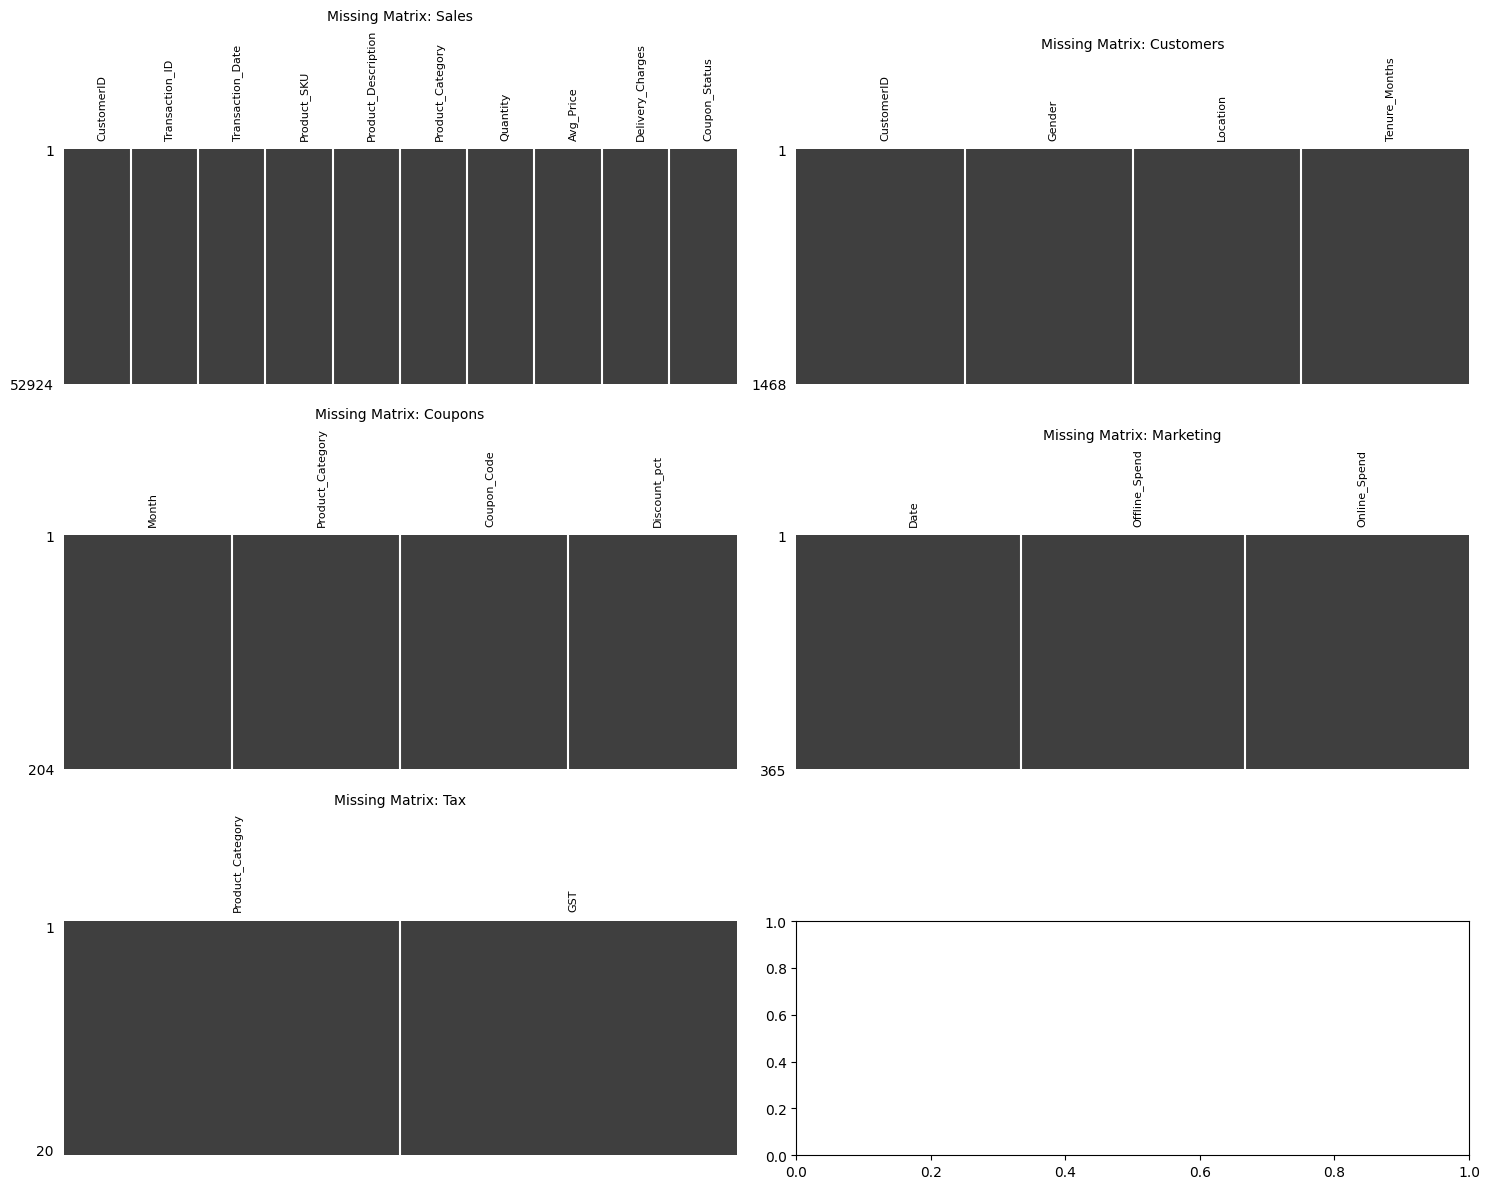

In [69]:
# Plot missing value matrix for each dataset
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()
for ax, (name, df) in zip(axes, datasets.items()):
    msno.matrix(df, ax=ax, sparkline=False, fontsize=8)
    ax.set_title(f"Missing Matrix: {name}", fontsize=10)
    plt.setp(ax.get_xticklabels(), rotation=90) # Rotate x-axis labels
plt.tight_layout();

Following the visualization of missing values, we will determine a tailored handling strategy for each feature. The approach will depend on the data type:

Numeric features: We will impute missing values with either the median (due to its robustness to outliers) or the mean. For example, we might use median imputation for fields like Tenure.

Categorical features: We will fill missing values with the mode or a new, distinct category like 'Unknown'. This applies to features such as Coupon_Status.

Time-series data: We will consider using methods such as forward or backward filling, depending on the context.

All imputation decisions will be guided by specific business logic and thoroughly documented for transparency.

In [70]:
# Impute missing values

# Customers Data: if 'Age' missing, fill with median age
if 'Tenure_Month' in customers.columns:
    median_age = customers['Tenure_Month'].median()
    customers['Age'] = customers['Tenure_Month'].fillna(median_age, inplace=True)

# Sales Data: fill missing 'Coupon_Status' with 0 (no coupon)
if 'Coupon_Status' in sales.columns:
    sales['Coupon_Status'].fillna(0, inplace=True)

# Marketing Spend: forward-fill if daily spend missing
if 'Online_Spend' in marketing.columns:
    marketing[['Online_Spend', 'Offline_Spend']] = marketing[['Online_Spend', 'Offline_Spend']].fillna(method='ffill')

# Confirm no missing remain (or minimal)
for name, df in datasets.items():
    missing_count = df.isnull().sum().sum()
    print(f"{name} missing values after imputation: {missing_count}")

Sales missing values after imputation: 0
Customers missing values after imputation: 0
Coupons missing values after imputation: 0
Marketing missing values after imputation: 0
Tax missing values after imputation: 0


We perform a univariate analysis to visualize the distribution of each key variable. We use specific plots tailored to the data type:

*   For continuous variables, histograms and KDE plots are used to illustrate their distribution.

*   Boxplots are utilized to identify outliers and determine the median of the data.

*   For categorical variables, countplots reveal the frequency of each category.

For example, we will examine variables such as sales transaction amounts, quantity, and customer demographics

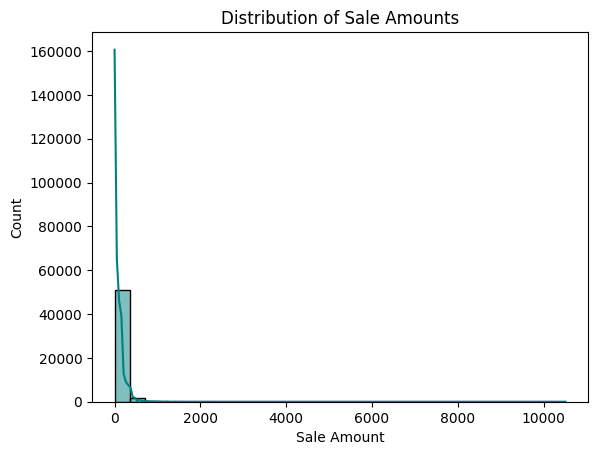

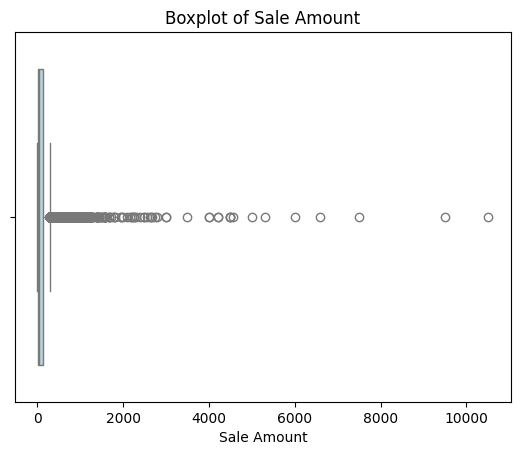

In [71]:
# Histogram and KDE of Sales Amount (price * quantity)
if all(col in sales.columns for col in ['Avg_Price', 'Quantity']):
    sales['SaleAmount'] = sales['Avg_Price'] * sales['Quantity']
    sns.histplot(sales['SaleAmount'], kde=True, color='teal', bins=30)
    plt.title('Distribution of Sale Amounts')
    plt.xlabel('Sale Amount')
    plt.ylabel('Count')
    plt.show()

# Boxplot for SaleAmount
if 'SaleAmount' in sales.columns:
    sns.boxplot(x=sales['SaleAmount'], color='lightblue')
    plt.title('Boxplot of Sale Amount')
    plt.xlabel('Sale Amount')
    plt.show()


We also inspect customer demographics:


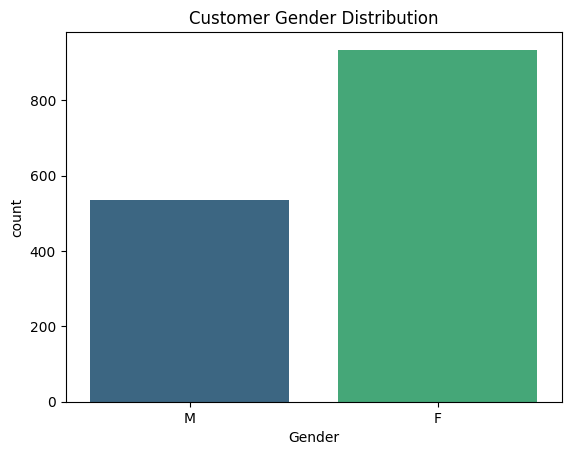

In [72]:
# Count plot for customer gender
if 'Gender' in customers.columns:
    sns.countplot(data=customers, x='Gender', palette='viridis')
    plt.title('Customer Gender Distribution')
    plt.show()

# Histogram of customer tenure (months)
if 'Tenure' in customers.columns:
    sns.histplot(customers['Tenure'], kde=True, color='orange', bins=20)
    plt.title('Customer Tenure Distribution')
    plt.xlabel('Tenure (months)')
    plt.show()

We will now explore the relationships between pairs of variables through bivariate and grouped analysis.

*   For bivariate analysis, we'll use scatter plots and correlation
heatmaps to identify trends. For example, we'll examine the correlation between sales and marketing spend.
*   For grouped analysis, we will group the data by different attributes, such as product category or customer location, to uncover aggregated patterns.

The ultimate goal is to compute aggregate metrics like total sales and order count by category and month to identify high-performing segments.

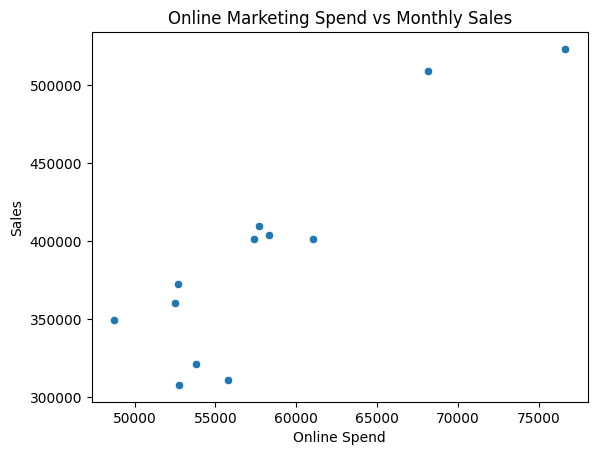

In [73]:
# Scatter plot: Marketing online spend vs Sales revenue (monthly aggregated)
if 'Date' in marketing.columns and 'Online_Spend' in marketing.columns and 'SaleAmount' in sales.columns:
    # Convert date columns
    marketing['Date'] = pd.to_datetime(marketing['Date'])
    sales['OrderDate'] = pd.to_datetime(sales['Transaction_Date'])
    # Aggregate monthly
    monthly_spend = marketing.resample('M', on='Date')[['Online_Spend', 'Offline_Spend']].sum().rename(columns={'Online_Spend':'OnlineSpend','Offline_Spend':'OfflineSpend'})
    monthly_sales = sales.resample('M', on='OrderDate')['SaleAmount'].sum()
    df_monthly = pd.concat([monthly_spend, monthly_sales], axis=1).dropna()
    sns.scatterplot(x='OnlineSpend', y='SaleAmount', data=df_monthly)
    plt.title('Online Marketing Spend vs Monthly Sales')
    plt.xlabel('Online Spend')
    plt.ylabel('Sales')
    plt.show()


Next, we examine categorical groupings. For instance, sales by product category or customer segment:


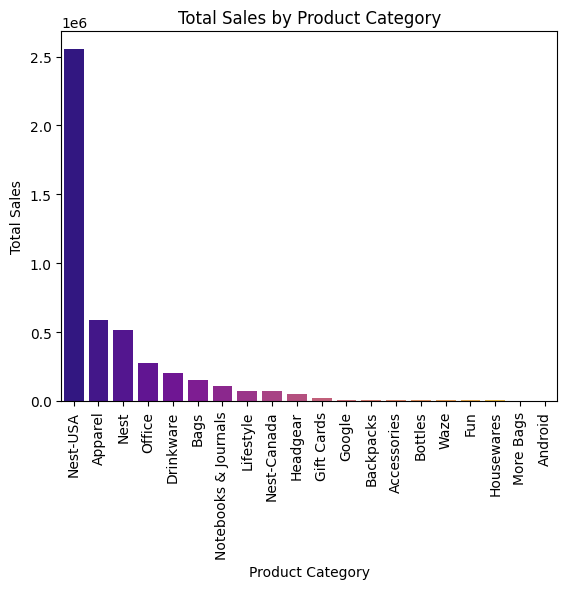

In [74]:
# Total sales by product category
if 'Product_Category' in sales.columns and 'SaleAmount' in sales.columns:
    sales_by_cat = sales.groupby('Product_Category')['SaleAmount'].sum().sort_values(ascending=False)
    sns.barplot(x=sales_by_cat.index, y=sales_by_cat.values, palette='plasma')
    plt.title('Total Sales by Product Category')
    plt.ylabel('Total Sales')
    plt.xlabel('Product Category')
    plt.xticks(rotation=90)
    plt.show()

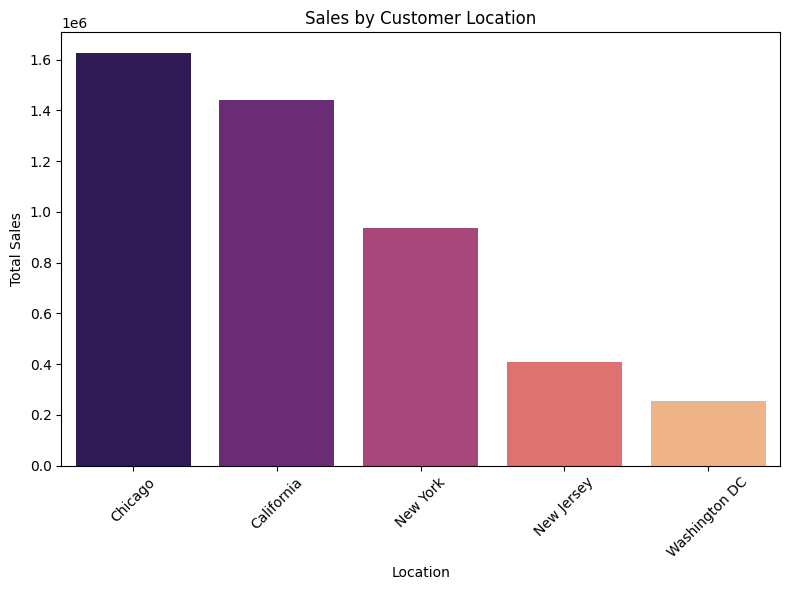

In [75]:
# Sales and order count by customer location
if 'Location' in customers.columns and 'CustomerID' in sales.columns:
    # Merge sales with customer location
    merged = pd.merge(sales, customers[['CustomerID','Location']], on='CustomerID', how='left')
    sales_by_loc = merged.groupby('Location')['SaleAmount'].sum().sort_values(ascending=False)
    orders_by_loc = merged.groupby('Location')['SaleAmount'].count().sort_values(ascending=False)
    fig, ax1 = plt.subplots(figsize=(8,6))
    sns.barplot(x=sales_by_loc.index, y=sales_by_loc.values, palette='magma', ax=ax1)
    ax1.set_ylabel('Total Sales')
    ax1.set_xlabel('Location')
    ax1.set_title('Sales by Customer Location')
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    plt.tight_layout()
    plt.show()

## Time-Based and Location-Based Trends

We analyze how sales vary over time (daily/weekly/monthly) and across geographical locations. Time series plots can reveal seasonality and trends. For example:


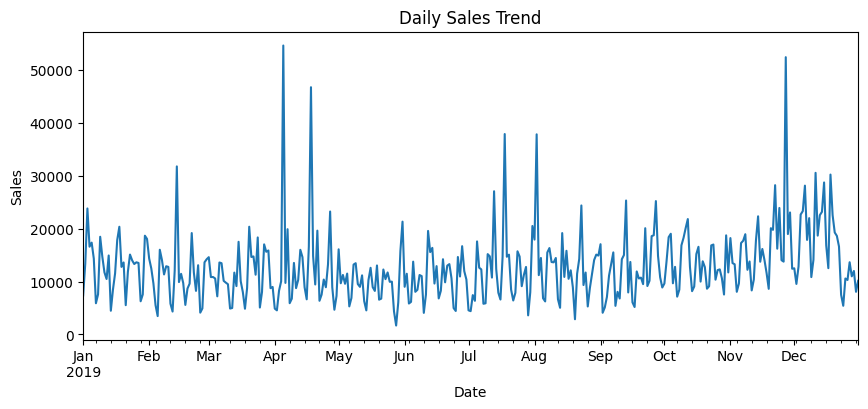

In [76]:
# Time series: daily sales trend
if 'OrderDate' in sales.columns:
    daily_sales = sales.resample('D', on='OrderDate')['SaleAmount'].sum()
    plt.figure(figsize=(10,4))
    daily_sales.plot()
    plt.title('Daily Sales Trend')
    plt.ylabel('Sales')
    plt.xlabel('Date')
    plt.show()


For location-based trends, we might map sales by city or region (if data available), or compare conversion rates across locations using bar charts or heatmaps.

## Correlation & Feature Relationships
We will use a correlation matrix and heatmap to identify linear relationships and multicollinearity among the numeric features. This analysis is crucial for finding highly correlated features, such as order quantity and sale amount, which could be candidates for dimensionality reduction or feature selection. The process begins with computing the correlation matrix on all numeric fields.

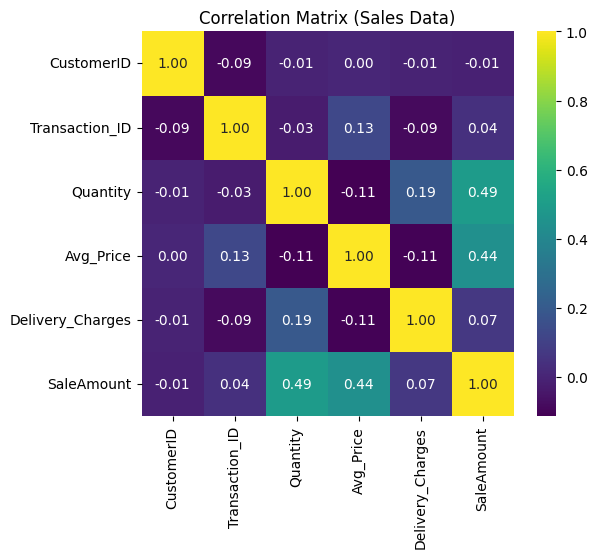

In [77]:
# Correlation heatmap for numeric variables in sales data
numeric_sales = sales.select_dtypes(include=np.number)
if not numeric_sales.empty:
    corr = numeric_sales.corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlation Matrix (Sales Data)')
    plt.show()

If two features are nearly perfectly correlated, we may drop one to avoid redundancy. For example, if `SaleAmount` = `Price` * `Quantity`, and we keep `SaleAmount`, we might drop the original columns after analysis to avoid multicollinearity.

## Outlier Detection & Removal

We detect outliers using boxplots and statistical methods like the IQR or Z-score, as these data points can skew analysis and model training. For instance, we identify exceptionally high sales amounts or unusually long customer tenures. Based on domain knowledge, these outliers will be either capped at a certain value or removed from the dataset.

In [78]:
# Identify outliers in SaleAmount using IQR
if 'SaleAmount' in sales.columns:
    Q1 = sales['SaleAmount'].quantile(0.25)
    Q3 = sales['SaleAmount'].quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sales[(sales['SaleAmount'] < lower_bound) | (sales['SaleAmount'] > upper_bound)]
    print(f"Identified {outliers.shape[0]} outlier transactions based on SaleAmount.")
    # Optionally, remove or flag these outliers
    sales_clean = sales[~((sales['SaleAmount'] < lower_bound) | (sales['SaleAmount'] > upper_bound))]
    print(f"After removal, {sales_clean.shape[0]} records remain.")

Identified 3632 outlier transactions based on SaleAmount.
After removal, 49292 records remain.


## Domain-Specific Insights

Beyond general EDA, we perform specialized analyses relevant to marketing and customer analytics:

### Customer Segmentation (RFM + K-Means)
To perform customer segmentation, we first calculate the Recency, Frequency, and Monetary (RFM) values for each customer. This popular marketing technique ranks customers based on their purchasing behavior. We then apply K-Means clustering to these RFM features to define distinct customer segments, such as 'High-Value Loyal' and 'Low-Value New'.


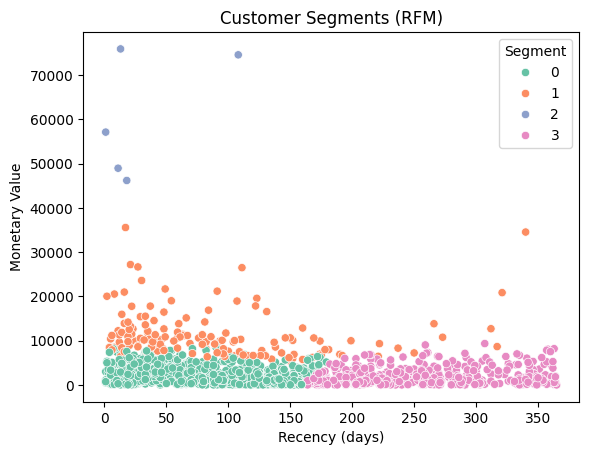

In [79]:
# Compute RFM metrics for each customer
if 'OrderDate' in sales.columns and 'CustomerID' in sales.columns:
    snapshot_date = sales['OrderDate'].max() + pd.Timedelta(days=1)
    rfm_df = sales.groupby('CustomerID').agg({
        'OrderDate': lambda x: (snapshot_date - x.max()).days,
        'Transaction_ID': 'count',
        'SaleAmount': 'sum'
    }).rename(columns={'OrderDate': 'Recency', 'Transaction_ID': 'Frequency', 'SaleAmount': 'Monetary'})
    # Clustering on RFM
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_df)
    kmeans = KMeans(n_clusters=4, random_state=42)
    rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)
    sns.scatterplot(x=rfm_df['Recency'], y=rfm_df['Monetary'], hue=rfm_df['Segment'], palette='Set2')
    plt.title('Customer Segments (RFM)')
    plt.xlabel('Recency (days)')
    plt.ylabel('Monetary Value')
    plt.show()

### Churn Prediction
We define churn (e.g., customer has no orders in last 3 months) and build classification models to predict churners. We may engineer features such as recency or purchase frequency. We evaluate Logistic Regression and Random Forest, comparing ROC curves and AUC.


Logistic Regression AUC: 1.00, Random Forest AUC: 1.00


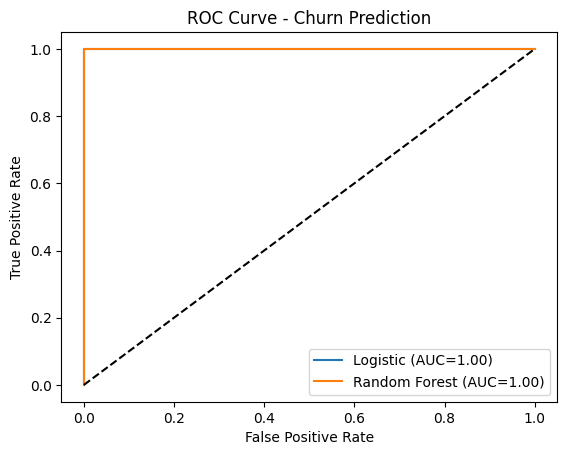

In [80]:
# Prepare data for churn prediction
if 'Recency' in rfm_df.columns:
    # Example: label churn = 1 if Recency > threshold
    churn_threshold = 90
    rfm_df['Churn'] = (rfm_df['Recency'] > churn_threshold).astype(int)
    X = rfm_df[['Recency', 'Frequency', 'Monetary']]
    y = rfm_df['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred_proba = logreg.predict_proba(X_test)[:,1]
    auc_log = roc_auc_score(y_test, y_pred_proba)
    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
    auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
    print(f"Logistic Regression AUC: {auc_log:.2f}, Random Forest AUC: {auc_rf:.2f}")
    # Plot ROC curves
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
    plt.figure()
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={auc_log:.2f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.title('ROC Curve - Churn Prediction')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### Cohort Analysis
We construct cohorts based on the month of first purchase to study retention. By pivoting a cohort table (cohort index vs month offset), we measure retention rates over time.

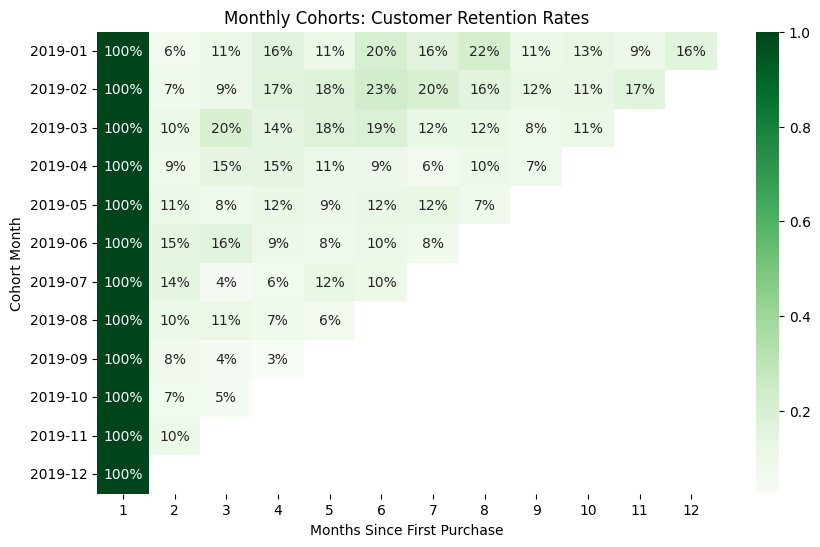

In [81]:
# Cohort analysis: assign each customer to cohort (first purchase month)
if 'OrderDate' in sales.columns and 'CustomerID' in sales.columns:
    sales['OrderMonth'] = sales['OrderDate'].dt.to_period('M')
    sales['CohortMonth'] = sales.groupby('CustomerID')['OrderMonth'].transform('min')
    cohort_data = sales.groupby(['CohortMonth', 'OrderMonth'])['CustomerID'].nunique().reset_index()
    cohort_data['CohortPeriod'] = (cohort_data['OrderMonth'].dt.year - cohort_data['CohortMonth'].dt.year) * 12 + (cohort_data['OrderMonth'].dt.month - cohort_data['CohortMonth'].dt.month) + 1
    cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortPeriod', values='CustomerID')
    cohort_sizes = cohort_counts.iloc[:,0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    plt.figure(figsize=(10,6))
    sns.heatmap(retention, annot=True, fmt='.0%', cmap='Greens')
    plt.title('Monthly Cohorts: Customer Retention Rates')
    plt.ylabel('Cohort Month')
    plt.xlabel('Months Since First Purchase')
    plt.show()

### Customer Lifetime Value (CLV) Prediction
We estimate each customer's lifetime value. One approach is to model CLV with regression using historical revenue per customer as the target. We may classify CLV into categories (low/medium/high) for easier business action. We will use regression models to predict CLV and evaluate performance (RMSE or classification accuracy).


In [82]:
# Prepare features and target for CLV prediction
if 'Monetary' in rfm_df.columns:
    # Use Monetary (total spend) as proxy for CLV
    X = rfm_df[['Recency', 'Frequency']]
    y = rfm_df['Monetary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
    print(f"Linear Regression Mean Squared Error for CLV: {rmse:.2f}")

Linear Regression Mean Squared Error for CLV: 2882869.45


### Marketing Spend Efficiency
We analyze the efficiency of our marketing spend by calculating the Return on Investment (ROI). This is done by comparing the revenue generated to the marketing expenditure for different channels. For example, we can calculate the monthly ROI for both online and offline channels using the formula: (Revenue - Spend) / Spend.







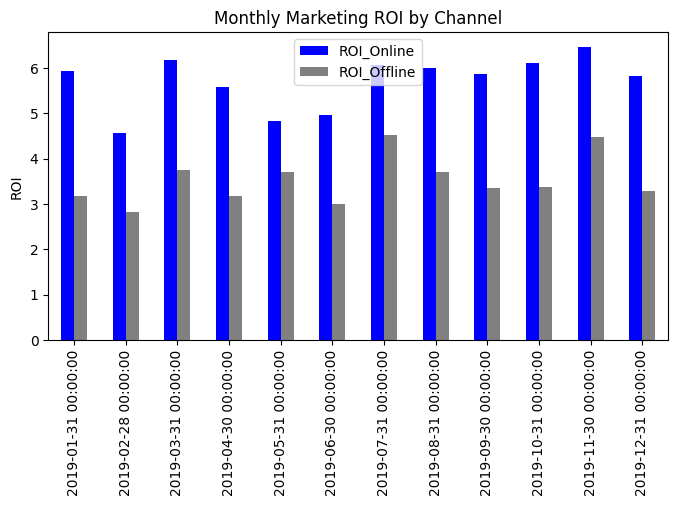

In [83]:
# ROI analysis by channel
if 'OnlineSpend' in monthly_spend.columns and 'SaleAmount' in df_monthly.columns:
    monthly_df = df_monthly.copy()
    monthly_df['ROI_Online'] = (monthly_df['SaleAmount'] - monthly_df['OnlineSpend']) / monthly_df['OnlineSpend']
    monthly_df['ROI_Offline'] = (monthly_df['SaleAmount'] - monthly_df['OfflineSpend']) / monthly_df['OfflineSpend']
    monthly_df[['ROI_Online', 'ROI_Offline']].plot(kind='bar', figsize=(8,4), color=['blue', 'gray'])
    plt.title('Monthly Marketing ROI by Channel')
    plt.ylabel('ROI')
    plt.show()

### Coupon Usage Analysis
We'll analyze the frequency of coupon usage and its impact on order amounts. This can be accomplished by comparing the average order value for orders with and without coupons, or by using a groupby operation on the Coupon_Status flag.

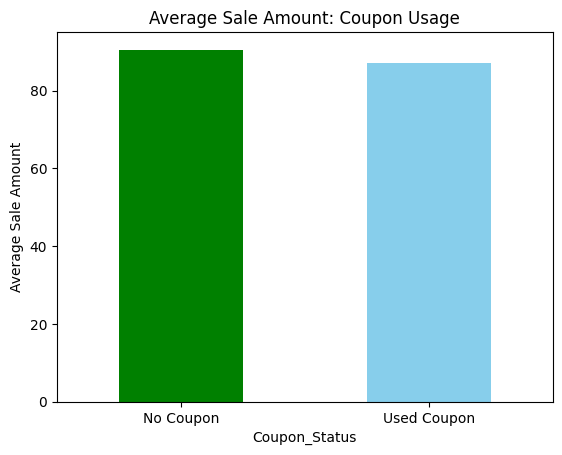

In [84]:
# Compare average sale amount with and without coupon
if 'Coupon_Status' in sales.columns and 'SaleAmount' in sales.columns:
    filtered = sales[sales['Coupon_Status'].isin(['Used', 'Not Used'])]
    means = filtered.groupby('Coupon_Status')['SaleAmount'].mean()
    means = means.reindex(['Not Used', 'Used'])
    means.plot(kind='bar', color=['green', 'skyblue'])
    plt.title('Average Sale Amount: Coupon Usage')
    plt.ylabel('Average Sale Amount')
    plt.xticks([0, 1], ['No Coupon', 'Used Coupon'], rotation=0)
    plt.show()

### Product Performance Analysis
Identify top-selling products by units and by revenue. Analyze product-level trends and how discounts impact demand.


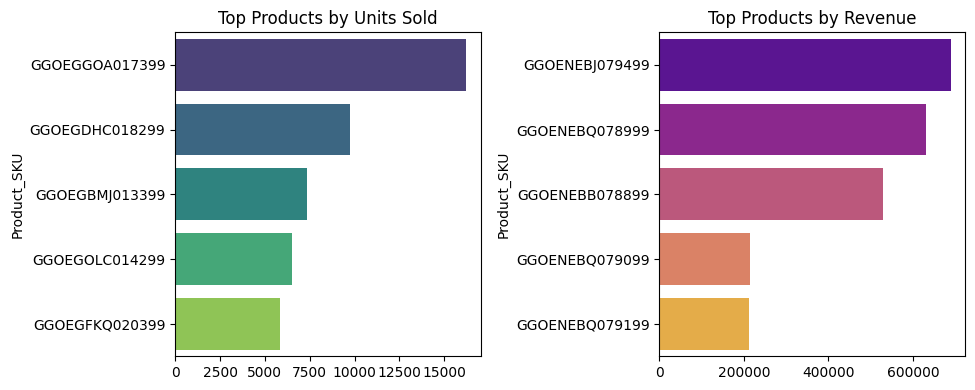

In [85]:
# Top products by quantity and revenue
if 'Product_SKU' in sales.columns:
    prod_qty = sales.groupby('Product_SKU')['Quantity'].sum().nlargest(5)
    prod_rev = sales.groupby('Product_SKU')['SaleAmount'].sum().nlargest(5)
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.barplot(x=prod_qty.values, y=prod_qty.index, ax=axes[0], palette='viridis')
    axes[0].set_title('Top Products by Units Sold')
    sns.barplot(x=prod_rev.values, y=prod_rev.index, ax=axes[1], palette='plasma')
    axes[1].set_title('Top Products by Revenue')
    plt.tight_layout()
    plt.show()

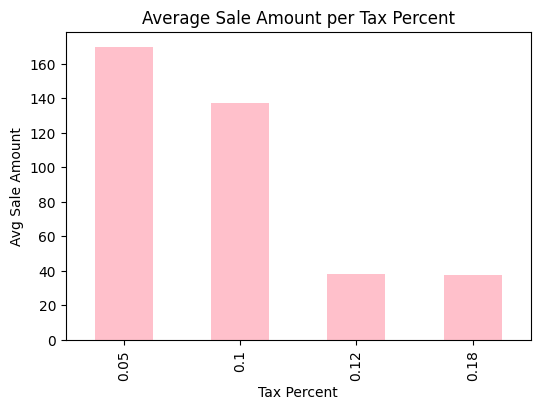

In [86]:
# Merge tax rates into sales and analyze
if 'Product_Category' in sales.columns and 'GST' in tax.columns:
    sales_tax = pd.merge(sales, tax, on='Product_Category', how='left')
    # Average sale amount by tax bracket
    avg_by_tax = sales_tax.groupby('GST')['SaleAmount'].mean().sort_index()
    avg_by_tax.plot(kind='bar', figsize=(6,4), color='pink')
    plt.title('Average Sale Amount per Tax Percent')
    plt.xlabel('Tax Percent')
    plt.ylabel('Avg Sale Amount')
    plt.show()